In [10]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [11]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [12]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_history_sentiment.csv', index_col = "date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns = "fng_classification")
df = df.drop('Unnamed: 3', axis=1)
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [13]:
# Load the historical closing prices for bitcoin
df2 = pd.read_csv('btc_price_data.csv', index_col = "Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [14]:
# Join the data into a single DataFrame
df = df.join(df2, how = "inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [15]:
df.head()

,fng_value,Close
2018-01-02,30,14754.12988
2018-01-03,38,15156.62012
2018-01-04,16,15180.08008
2018-01-05,56,16954.77930
2018-01-06,24,17172.30078


In [16]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [17]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [18]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [19]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [20]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [22]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units = number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units = number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [23]:
# Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [24]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 1, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 1, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [25]:

# Train the model
# Use at least 50 epochs
# Do not shuffle the data
model.fit(X_train, y_train, epochs = 50, shuffle = False, batch_size = 1, verbose = 1)

Epoch 1/50
353/353 [==============================] - 3s 1ms/step - loss: 0.0405
Epoch 2/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 3/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 4/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 5/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 6/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 7/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 8/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 9/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 10/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 11/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 12/50
353/353 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 13/50
353/353 [====

In [26]:
# Evaluate the model
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 1ms/step - loss: 0.0065


0.00652803061529994

In [27]:
# Make some predictions
predicted = model.predict(X_test)

5/5 [==============================] - 1s 1ms/step


In [28]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
# Create a DataFrame of Real and Predicted values
crypto = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
crypto.head()

,Real,Predicted
0,3467.209961,3793.821777
1,3467.209961,3820.920410
2,3434.129883,3820.920410
3,3461.629883,3802.598877
4,3508.679932,3817.826172


<AxesSubplot:>

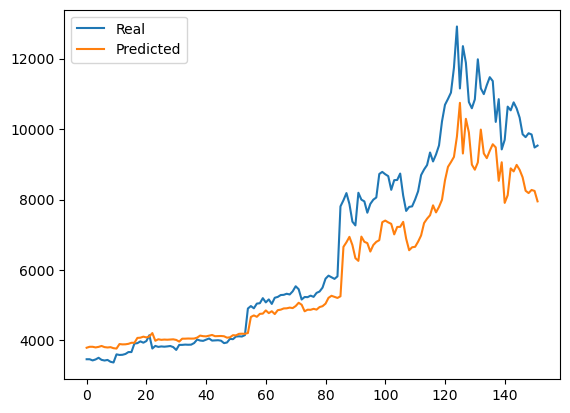

In [30]:
# Plot the real vs predicted values as a line chart
crypto.plot()